In [47]:
# Importa o Sympy
import sympy as sp

# Importa o Numpy
import numpy as np

# Importa o Matplot lib
import matplotlib.pyplot as plt

# Importa o módulo Toolbox
import Toolbox as T

u_plot = {}



In [48]:
# Variáveis simbólicas
x, L, E, A, alpha = sp.symbols('x L E A alpha')

# Parâmetros do modelo
n_elem = 5
n_nodes = n_elem + 1
h = L / n_elem

# Funções de forma locais
x_local = sp.Symbol('x')
N1 = 1 - x_local / h
N2 = x_local / h

# Derivadas
dN1 = sp.diff(N1, x_local)
dN2 = sp.diff(N2, x_local)

# Carregamento b(x) = alpha * x^2, mapeado para x_local
x_e = sp.Symbol('x_e')  # início do elemento
b_expr = alpha* (x_e + x_local)**2

# Inicializar sistema global
K_global = sp.zeros(n_nodes)
F_global = sp.zeros(n_nodes, 1)

# Montagem global
for e in range(1,n_elem+1):
    idx = [e-1, e]
    x_e_val = (e-1) * h
    b_local_e = b_expr.subs(x_e, x_e_val)
    
    # Matriz de rigidez local
    k_local = A * E * sp.Matrix([
    [sp.integrate(dN1 * dN1, (x_local, 0, h)), sp.integrate(dN1 * dN2, (x_local, 0, h))],
    [sp.integrate(dN2 * dN1, (x_local, 0, h)), sp.integrate(dN2 * dN2, (x_local, 0, h))]
    ])

    f_local_e = sp.Matrix([
        sp.integrate(N1 * b_local_e*A, (x_local, 0, h)),
        sp.integrate(N2 * b_local_e*A, (x_local, 0, h))
    ])

    for i in range(2):
        for j in range(2):
            K_global[idx[i], idx[j]] += k_local[i, j]
        F_global[idx[i]] += f_local_e[i]

# sp.pprint(sp.latex(K_global))
sp.pprint(K_global)


# Aplicar condição de contorno u(0) = 0
K_reduced = K_global[1:, 1:]
F_reduced = sp.Matrix(F_global[1:])

# Resolver sistema
u = sp.Matrix(sp.symbols(f'u1:{n_nodes}'))
sp.pprint(u)
sol = sp.solve(K_reduced * u - F_reduced, *u)

u_global = sp.Matrix([0] + list(u)).subs(sol)

⎡ 5⋅A⋅E   -5⋅A⋅E                                     ⎤
⎢ ─────   ───────     0        0        0        0   ⎥
⎢   L        L                                       ⎥
⎢                                                    ⎥
⎢-5⋅A⋅E   10⋅A⋅E   -5⋅A⋅E                            ⎥
⎢───────  ──────   ───────     0        0        0   ⎥
⎢   L       L         L                              ⎥
⎢                                                    ⎥
⎢         -5⋅A⋅E   10⋅A⋅E   -5⋅A⋅E                   ⎥
⎢   0     ───────  ──────   ───────     0        0   ⎥
⎢            L       L         L                     ⎥
⎢                                                    ⎥
⎢                  -5⋅A⋅E   10⋅A⋅E   -5⋅A⋅E          ⎥
⎢   0        0     ───────  ──────   ───────     0   ⎥
⎢                     L       L         L            ⎥
⎢                                                    ⎥
⎢                           -5⋅A⋅E   10⋅A⋅E   -5⋅A⋅E ⎥
⎢   0        0        0     ───────  ──────   ───────⎥
⎢         

In [49]:
# Inicializar função u(x)
u_expr = 0
u_piecewise = 0
for e in range(1,n_elem+1):
    x_e = (e-1) * h              # início do elemento
    x_ep1 = (e) * h      # fim do elemento
    xi = (x - x_e)           # coordenada local no elemento

    # Funções de forma locais em função de x
    N1 = 1 - xi / h
    N2 = xi / h

    # Nós locais
    u1e = u_global[e-1]
    u2e = u_global[e]

    # Função local de u(x)
    u_local = N1 * u1e + N2 * u2e

    # Adicionar como função por partes usando Piecewise
    u_piecewise += sp.Piecewise((u_local, (x >= x_e) & (x <= x_ep1)), (0, True))


u_plot[f'{n_elem}'] = u_piecewise


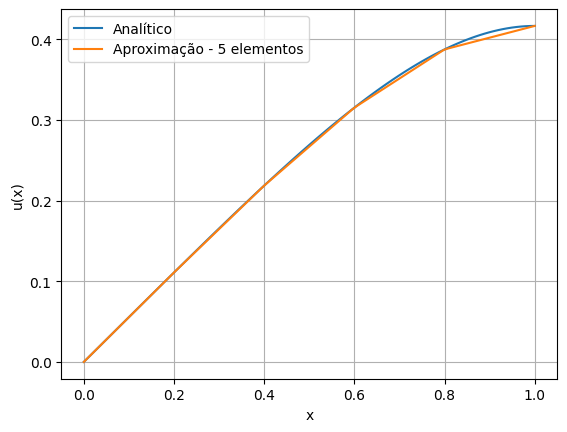

In [50]:
u_analitico = alpha*((-x**4)/(12*E) + (x*L**3)/(3*E))

subb = {alpha:5,E:1*10^9,L:1}

T.prepara_plot(u_analitico.subs(subb),x,0,1,'Analítico')
for i in u_plot.keys():
    T.prepara_plot(u_plot[i].subs(subb),x,0,1,f'Aproximação - {i} elementos')
plt.xlabel('x')
plt.ylabel('u(x)')
plt.grid(True)
plt.legend()
plt.show()